## 빅데이터 활용 AI 설계
# AutoEncoder
- https://blog.keras.io/building-autoencoders-in-keras.html

<img src='https://www.researchgate.net/profile/Xifeng_Guo/publication/320658590/figure/fig1/AS:614154637418504@1523437284408/The-structure-of-proposed-Convolutional-AutoEncoders-CAE-for-MNIST-In-the-middle-there.png' />
(출처: https://www.researchgate.net/figure/The-structure-of-proposed-Convolutional-AutoEncoders-CAE-for-MNIST-In-the-middle-there_fig1_320658590)

### 도전과제
- 잠재공간이 2차원인 인코더를 만들자.
- 학습을 시킨 후, 테스트 데이터에 대한 2차원 산점도를 그려보자. (각 점은 해당 숫자로 표시)

# MNIST 로딩

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from keras.datasets import mnist
(X_train, y_train), (X_test, y_test) = mnist.load_data()

Using TensorFlow backend.


In [3]:
X_train = X_train.reshape(-1,28,28,1)/255
X_test = X_test.reshape(-1,28,28,1)/255

X_train.shape, X_test.shape, X_train[0].max(), X_train[0].dtype

((60000, 28, 28, 1), (10000, 28, 28, 1), 1.0, dtype('float64'))

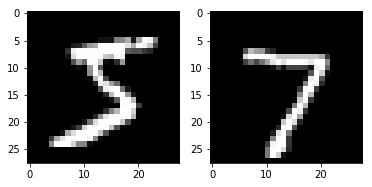

In [42]:
plt.subplot(1,2,1)
plt.imshow(X_train[0].reshape(28,28), cmap = 'gray')

plt.subplot(1,2,2)
plt.imshow(X_test[0].reshape(28,28), cmap = 'gray')

### 인코더 생성

In [6]:
from keras.models import Model
from keras.layers import Input, Conv2D, Flatten, Dense, Reshape, Conv2DTranspose

In [40]:
input = Input((28,28,1))

x = Conv2D(32,(3,3), strides = 2, padding = 'same', activation = 'relu')(input)
x = Conv2D(64,(3,3), strides = 2, padding = 'same', activation = 'relu')(x)
x = Conv2D(128,(3,3),strides = 2, activation = 'relu')(x)

x = Flatten()(x)
latent = Dense(2)(x)

In [11]:
encoder = Model(input, latent)
encoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 14, 14, 32)        320       
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 7, 7, 64)          18496     
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 3, 3, 128)         73856     
_________________________________________________________________
flatten_2 (Flatten)          (None, 1152)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 2306      
Total params: 94,978
Trainable params: 94,978
Non-trainable params: 0
_________________________________________________________________


### 디코더 생성

In [15]:
input2 = Input((2,))

x2 = Dense(3*3*128, activation = 'relu')(input2)
x2 = Reshape((3,3,128))(x2)

x2 = Conv2DTranspose(64,(3,3), strides = 2, activation = 'relu')(x2)
x2 = Conv2DTranspose(32,(3,3), strides = 2, padding = 'same', activation = 'relu')(x2)

output = Conv2DTranspose(1, (3,3), strides = 2, padding = 'same', activation = 'relu')(x2)


In [16]:
decoder = Model(input2, output)
decoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         (None, 2)                 0         
_________________________________________________________________
dense_4 (Dense)              (None, 1152)              3456      
_________________________________________________________________
reshape_1 (Reshape)          (None, 3, 3, 128)         0         
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 7, 7, 64)          73792     
_________________________________________________________________
conv2d_transpose_2 (Conv2DTr (None, 14, 14, 32)        18464     
_________________________________________________________________
conv2d_transpose_3 (Conv2DTr (None, 28, 28, 1)         289       
Total params: 96,001
Trainable params: 96,001
Non-trainable params: 0
_________________________________________________________________


### 오토인코더 구성

In [17]:
autoencoder = Model(input, decoder(encoder(input)))

autoencoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
model_1 (Model)              (None, 2)                 94978     
_________________________________________________________________
model_2 (Model)              (None, 28, 28, 1)         96001     
Total params: 190,979
Trainable params: 190,979
Non-trainable params: 0
_________________________________________________________________


In [18]:
autoencoder.compile(loss = 'mse', optimizer = 'rmsprop', metrics = ['accuracy'])

W0830 13:26:21.664302 13164 deprecation_wrapper.py:119] From C:\Users\user\Anaconda3\lib\site-packages\keras\optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.



In [25]:
autoencoder.fit(X_train, X_train, batch_size = 32, epochs = 1, validation_data = (X_test,X_test))

W0830 13:27:36.161595 13164 deprecation_wrapper.py:119] From C:\Users\user\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:986: The name tf.assign_add is deprecated. Please use tf.compat.v1.assign_add instead.

W0830 13:27:36.167580 13164 deprecation_wrapper.py:119] From C:\Users\user\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:973: The name tf.assign is deprecated. Please use tf.compat.v1.assign instead.



Train on 60000 samples, validate on 10000 samples
Epoch 1/1
60000/60000 [==============================] - 27s 449us/step - loss: 0.0522 - acc: 0.7986 - val_loss: 0.0456 - val_acc: 0.7989


### 평가

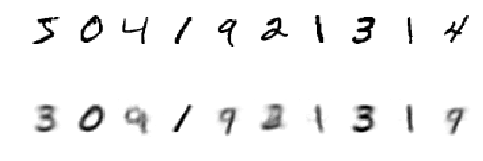

In [30]:
plt.figure(figsize = [8,3])

for i in range(10):
    r = autoencoder.predict(X_train[[i]])
    
    plt.subplot(2,10,1+i)
    plt.imshow(X_train[i,:,:,0], vmax = 1, vmin = 0, cmap = 'gray_r')
    plt.axis('off')
    
    plt.subplot(2,10,11+i)
    plt.imshow(r[0,:,:,0], vmax = 1, vmin = 0, cmap = 'gray_r')
    plt.axis('off')


### 시각화
- 잠재공간 10차원 중 앞 2차원을 활용

In [31]:
latent_value = encoder.predict(X_train)

In [32]:
latent_value.shape

(60000, 2)

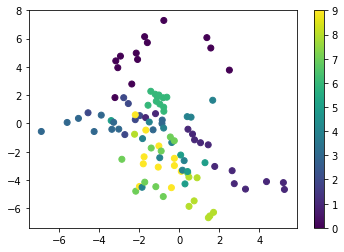

In [33]:
plt.scatter(latent_value[:100,0], latent_value[:100,1], c = y_train[:100])
plt.colorbar()

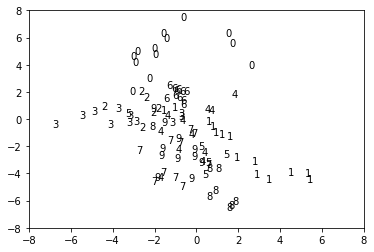

In [47]:
plt.axis([-8,8,-8,8])
for i in range(100):
    plt.text(latent_value[i,0], latent_value[i,1], str(y_train[i]))